In [1]:
import astropy
from astropy.io import fits
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from matplotlib.colors import LogNorm
from astropy import units as u
import galpy
from galpy.orbit import Orbit
from astropy.coordinates import SkyCoord
from galpy.potential import MWPotential2014
from astropy.coordinates import SkyCoord, Galactocentric, CartesianDifferential
from matplotlib.colors import Normalize
from matplotlib.patches import Ellipse, Circle
import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
import pygmmis
from sklearn.cluster import KMeans

In [2]:
vphi_data = 'df_v_final.fits'

with fits.open(vphi_data) as hdul:
    data = hdul[1].data  
    
    df_v = pd.DataFrame({col.name: data[col.name].byteswap().newbyteorder() if data[col.name].dtype.byteorder == '>' else data[col.name]
                       for col in hdul[1].columns})

In [3]:
df_v = df_v[np.abs(df_v['Z']) < 2.5]
df_v = df_v.dropna(subset=["v_R", "v_phi", "v_R_uncertainty", "v_phi_uncertainty", "v_Z", "v_Z_uncertainty"])

In [4]:
import pandas as pd
from tqdm import tqdm

def filter_metallicity_bin(df, min_mh, max_mh):
    """
    Filter the dataframe to get stars in the specified metallicity range.
    Args:
    - df: The dataframe containing the data.
    - min_mh: The minimum metallicity value.
    - max_mh: The maximum metallicity value.
    
    Returns:
    - df_bin: The filtered dataframe containing only the stars in the metallicity range.
    """
    df_bin = df[(df['mh_xgboost'] >= min_mh) & (df['mh_xgboost'] < max_mh)]
    return df_bin


In [5]:
df_vmp = filter_metallicity_bin(df_v,-3,-2)
df_imp = filter_metallicity_bin(df_v,-2,-1.6)
df_mp1 = filter_metallicity_bin(df_v,-1.6,-1.3)
df_mp2 = filter_metallicity_bin(df_v,-1.3,-1)

In [6]:
import numpy as np
import pygmmis
import matplotlib.pyplot as plt
from tqdm import tqdm

def compute_bic_vs_n_components(df_bin, max_components=8, n_init=50, init_method='random'):
    """
    Compute BIC for different numbers of Gaussian components (1 to max_components),
    using a normalized velocity space.

    Args:
    - df_bin: DataFrame containing the data for a metallicity bin.
    - max_components: Maximum number of components to test.
    - n_init: Number of different random initializations per component count.
    - init_method: Initialization method ('random', 'kmeans', 'minmax', 'none').

    Returns:
    - BIC_values: Dictionary storing min, median, and max BIC for each component count.
    """
    # Extract raw velocity data
    X_raw = df_bin[['v_R', 'v_phi', 'v_Z']].values  
    n = len(X_raw)  # Number of stars

    # Normalize velocity space (Min-Max Scaling)
    X_min = np.min(X_raw, axis=0)
    X_max = np.max(X_raw, axis=0)
    X_normalized = (X_raw - X_min) / (X_max - X_min)  # Normalize velocities

    # Handle potential division by zero in case of constant values
    X_normalized = np.nan_to_num(X_normalized, nan=0.0, posinf=1.0, neginf=0.0)

    # Normalize measurement uncertainties
    uncertainties = np.stack([
        df_bin['v_R_uncertainty'].values**2,
        df_bin['v_phi_uncertainty'].values**2,
        df_bin['v_Z_uncertainty'].values**2
    ], axis=1)
    
    # Normalize uncertainties using the same scaling factors as velocity data
    uncertainties_normalized = uncertainties / (X_max - X_min)**2

    # Construct per-star diagonal covariance matrices
    cov_matrices = np.array([np.diag(uncertainty) for uncertainty in uncertainties_normalized])

    BIC_values = {N: [] for N in range(1, max_components + 1)}

    print("\nComputing BIC for different numbers of components in normalized space...")
    rng = np.random.RandomState()

    for N in tqdm(range(1, max_components + 1), desc="Fitting GMMs"):
        for _ in range(n_init):  # Run multiple initializations per N
            gmm = pygmmis.GMM(K=N, D=3)  # GMM in 3D normalized velocity space

            # **Choose Initialization Method**
            if init_method == 'random':
                pygmmis.initFromDataAtRandom(gmm, X_normalized, rng=rng)
            elif init_method == 'kmeans':
                pygmmis.initFromKMeans(gmm, X_normalized)
            elif init_method == 'minmax':
                pygmmis.initFromDataMinMax(gmm, X_normalized)
            elif init_method == 'none':  # Custom initialization
                gmm.amp = np.ones(N) / N  # Equal weights
                gmm.mean = np.random.uniform(0, 1, (N, 3))  # Initialize means within normalized range
                gmm.covar = np.array([np.eye(3) for _ in range(N)])  # Identity covariance

            # Fit GMM with Extreme Deconvolution (ED) to account for measurement errors
            logL, _ = pygmmis.fit(gmm, X_normalized, covar_callback=lambda _: cov_matrices)

            # Compute BIC using BIC = k*ln(n) - 2*logL
            k = (1 + 3 + 6) * N - 1  # Number of parameters for N components
            BIC = k * np.log(n) - 2 * logL
            BIC_values[N].append(BIC)

    return BIC_values


In [7]:
def plot_bic_vs_n_components(BIC_values):
    """
    Plots BIC vs. Number of Components.

    Args:
    - BIC_values: Dictionary with BIC values for each component count.
    """
    num_components = sorted(BIC_values.keys())  # Sorted list of component numbers
    
    smallest_bic = [min(BIC_values[N]) for N in num_components]
    median_bic = [np.median(BIC_values[N]) for N in num_components]
    largest_bic = [max(BIC_values[N]) for N in num_components]
    q25_bic = [np.percentile(BIC_values[N], 25) for N in num_components]  # 25th percentile
    q75_bic = [np.percentile(BIC_values[N], 75) for N in num_components]  # 75th percentile

    plt.figure(figsize=(8, 6))
    plt.plot(num_components, smallest_bic, 'k-', label='Smallest BIC')
    plt.plot(num_components, q25_bic, 'g-.', label='25th Percentile BIC')
    plt.plot(num_components, median_bic, 'b--', label='Median BIC')
    plt.plot(num_components, q75_bic, 'g-.', label='75th Percentile BIC')
    plt.plot(num_components, largest_bic, 'r:', label='Largest BIC')

    plt.xlabel("Number of GMM Components")
    plt.ylabel("BIC Value")
    plt.title("BIC vs Number of Components")
    plt.legend()
    plt.grid(True)
    plt.show()

In [8]:
# Example usage:
bic_values_vmp = compute_bic_vs_n_components(df_vmp, max_components=8, n_init=50, init_method='random')


Computing BIC for different numbers of components in normalized space...


Fitting GMMs: 100%|██████████| 8/8 [11:31<00:00, 86.48s/it] 


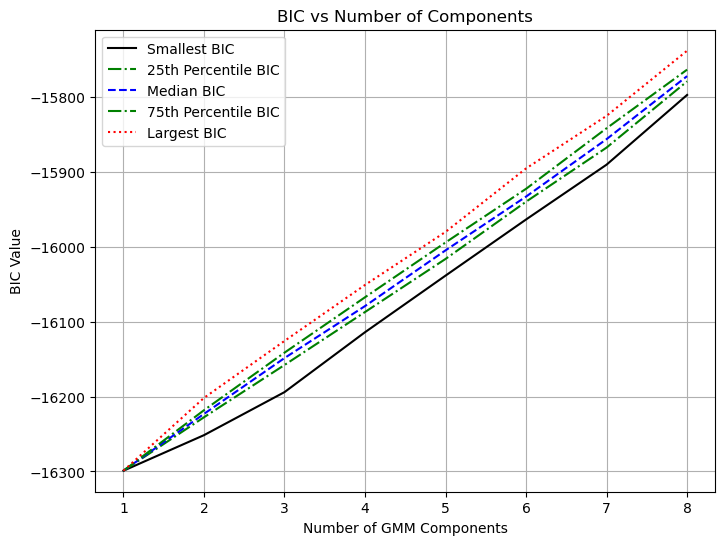

In [9]:
plot_bic_vs_n_components(bic_values_vmp)

In [29]:
import numpy as np
import pygmmis
import matplotlib.pyplot as plt
from tqdm import tqdm
from matplotlib.patches import Ellipse

def normalize_data(X):
    """Min-max normalization of data."""
    X_min = np.min(X, axis=0)
    X_max = np.max(X, axis=0)
    X_norm = (X - X_min) / (X_max - X_min)
    
    # Handle potential division by zero
    X_norm = np.nan_to_num(X_norm, nan=0.0, posinf=1.0, neginf=0.0)
    
    return X_norm, X_min, X_max  # Return min/max for later denormalization

def fit_gmm(df_bin, n_components, n_init=200):
    """
    Fits a GMM using Extreme Deconvolution, accounting for measurement errors in normalized space.

    Args:
    - df_bin: DataFrame for a given metallicity bin.
    - n_components: Number of Gaussian components to use.
    - n_init: Number of initializations to find the best log-likelihood.

    Returns:
    - best_gmm: The best-fit GMM model.
    - X_min, X_max: Min/max values for denormalization.
    """
    X_raw = df_bin[['v_R', 'v_phi', 'v_Z']].values  # Raw velocity data
    X_norm, X_min, X_max = normalize_data(X_raw)  # Normalize the velocities

    # Normalize uncertainties
    uncertainties = np.stack([
        df_bin['v_R_uncertainty'].values**2,
        df_bin['v_phi_uncertainty'].values**2,
        df_bin['v_Z_uncertainty'].values**2
    ], axis=1)
    uncertainties_norm = uncertainties / (X_max - X_min)**2  # Scale uncertainties

    # Construct per-star diagonal covariance matrices
    cov_matrices = np.array([np.diag(uncertainty) for uncertainty in uncertainties_norm])

    best_gmm = None
    best_logL = -np.inf

    for _ in tqdm(range(n_init), desc=f"Fitting GMM with {n_components} components"):
        gmm = pygmmis.GMM(K=n_components, D=3)
        logL, _ = pygmmis.fit(gmm, X_norm, covar_callback=lambda _: cov_matrices)

        if logL > best_logL:
            best_logL = logL
            best_gmm = gmm

    return best_gmm, X_min, X_max  # Return min/max values for denormalization

def denormalize_values(values, X_min, X_max):
    """Denormalizes a dataset from min-max scaling."""
    return values * (X_max - X_min) + X_min




In [30]:
def plot_gmm_ellipses(df_bin, gmm, bin_label, X_min, X_max):
    """
    Plots v_phi vs v_R with 2σ ellipses for the GMM components in denormalized space.

    Args:
    - df_bin: DataFrame containing v_R and v_phi data.
    - gmm: Best-fit Gaussian Mixture Model.
    - bin_label: String label for the metallicity bin.
    - X_min, X_max: Min/max values for denormalization.
    """
    # Normalize data for plotting
    X_raw = df_bin[['v_R', 'v_phi', 'v_Z']].values
    X_norm, _, _ = normalize_data(X_raw)  # Normalize the data

    fig, ax = plt.subplots(figsize=(8, 6))
    
    # Scatter plot of data points (denormalized)
    ax.scatter(df_bin['v_R'], df_bin['v_phi'], alpha=0.3, s=3, color='black', label="Data")

    # Define colors for different components
    colors = ['red', 'blue', 'green', 'orange', 'purple', 'aqua', 'gold', 'brown']

    # Plot 2σ ellipses for each GMM component
    for i in range(len(gmm.amp)):
        mean_norm = gmm.mean[i][:2]  # (v_R, v_phi) mean in normalized space
        cov_norm = gmm.covar[i][:2, :2]  # 2D covariance matrix in normalized space

        # Denormalize mean and covariance for plotting
        mean = denormalize_values(mean_norm, X_min[:2], X_max[:2])
        cov = np.diag((X_max[:2] - X_min[:2])) @ cov_norm @ np.diag((X_max[:2] - X_min[:2]))

        # Eigen decomposition to get ellipse properties
        eigvals, eigvecs = np.linalg.eigh(cov)
        order = eigvals.argsort()[::-1]
        eigvals, eigvecs = eigvals[order], eigvecs[:, order]

        angle = np.degrees(np.arctan2(*eigvecs[:, 0][::-1]))  # Rotation angle
        width, height = 2 * 2 * np.sqrt(eigvals)  # 2σ standard deviation

        ell = Ellipse(xy=mean, width=width, height=height, angle=angle,
                      edgecolor=colors[i % len(colors)], facecolor='none', lw=2, label=f"Component {i+1}")
        ax.add_patch(ell)

    # Set labels and legend
    ax.set_xlabel(r'$v_R$ (km/s)')
    ax.set_ylabel(r'$v_\phi$ (km/s)')
    ax.set_title(f"Optimum GMM for {bin_label}")
    ax.legend()
    ax.grid(True)
    
    plt.show()

In [31]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from scipy.stats import gaussian_kde

def plot_gmm_ellipses(df_bin, gmm, bin_label, X_min, X_max, bins=100, x_limits=(-400, 400), y_limits=(-400, 400)):
    """
    Plots v_phi vs v_R with a scatter plot where intensity is normalized, along with 2σ ellipses for GMM components.

    Args:
    - df_bin: DataFrame containing v_R and v_phi data.
    - gmm: Best-fit Gaussian Mixture Model.
    - bin_label: String label for the metallicity bin.
    - X_min, X_max: Min/max values for denormalization.
    - bins: Number of bins for density estimation.
    - x_limits, y_limits: Axis limits for visualization.
    """
    fig, ax = plt.subplots(figsize=(8, 6))

    # Extract raw velocity values
    v_R = df_bin['v_R'].values
    v_phi = df_bin['v_phi'].values

    # Compute 2D histogram for density normalization
    H, xedges, yedges = np.histogram2d(v_R, v_phi, bins=bins, range=[x_limits, y_limits], density=True)

    # Normalize the histogram (Min-Max scaling)
    H_min = np.min(H[H > 0]) if np.any(H > 0) else 1e-5
    H_max = np.max(H) if np.max(H) > 0 else 1
    H_normalized = (H - H_min) / (H_max - H_min)
    H_normalized = np.clip(H_normalized, 0, 1)

    # Create a density function from the scatter points
    kde = gaussian_kde(np.vstack([v_R, v_phi]))  
    density = kde(np.vstack([v_R, v_phi]))

    # Normalize scatter intensity
    density_min, density_max = np.min(density), np.max(density)
    density_norm = (density - density_min) / (density_max - density_min)
    
    # Scatter plot with density-based alpha
    ax.scatter(v_R, v_phi, c=density_norm, cmap="Greys", s=3, alpha=0.5, label="Data (Density Normalized)")

    # Define colors for different components
    colors = ['red', 'blue', 'green', 'orange', 'purple', 'aqua', 'gold', 'brown']

    # Plot 2σ ellipses for each GMM component
    for i in range(len(gmm.amp)):
        mean_norm = gmm.mean[i][:2]  # Mean in normalized space
        cov_norm = gmm.covar[i][:2, :2]  # 2D covariance matrix in normalized space

        # Denormalize mean and covariance for plotting
        mean = denormalize_values(mean_norm, X_min[:2], X_max[:2])
        cov = np.diag((X_max[:2] - X_min[:2])) @ cov_norm @ np.diag((X_max[:2] - X_min[:2]))

        # Eigen decomposition to get ellipse properties
        eigvals, eigvecs = np.linalg.eigh(cov)
        order = eigvals.argsort()[::-1]
        eigvals, eigvecs = eigvals[order], eigvecs[:, order]

        angle = np.degrees(np.arctan2(*eigvecs[:, 0][::-1]))  # Rotation angle
        width, height = 2 * 2 * np.sqrt(eigvals)  # 2σ standard deviation

        ell = Ellipse(xy=mean, width=width, height=height, angle=angle,
                      edgecolor=colors[i % len(colors)], facecolor='none', lw=2, label=f"Component {i+1}")
        ax.add_patch(ell)

    # Set labels and legend
    ax.set_xlabel(r'$v_R$ (km/s)')
    ax.set_ylabel(r'$v_\phi$ (km/s)')
    ax.set_title(f"Optimum GMM for {bin_label} (Density Normalized)")
    ax.legend()
    ax.grid(True)
    
    plt.show()


In [27]:
gmm_mp1,Xmin,Xmax = fit_gmm(df_mp1, 5)

Fitting GMM with 5 components: 100%|██████████| 100/100 [02:37<00:00,  1.58s/it]


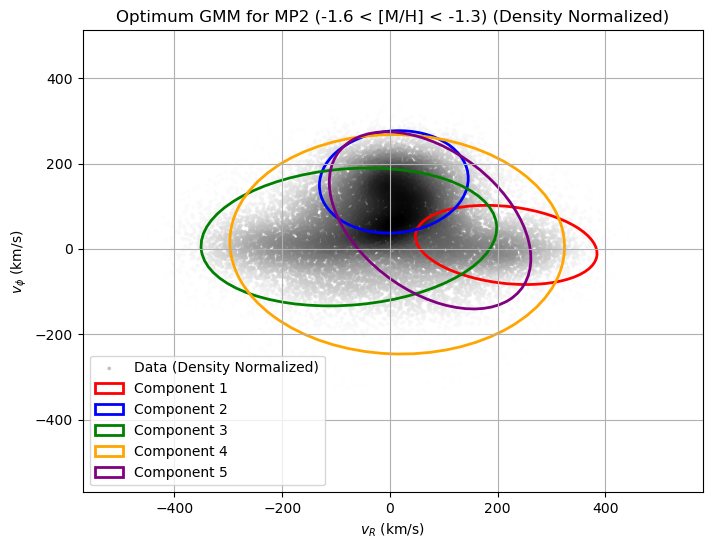

In [28]:
plot_gmm_ellipses(df_mp1, gmm_mp1, "MP2 (-1.6 < [M/H] < -1.3)",Xmin,Xmax)

In [14]:
gmm_mp2,Xmin,Xmax = fit_gmm(df_mp2, 5)

Fitting GMM with 5 components: 100%|██████████| 50/50 [01:25<00:00,  1.72s/it]


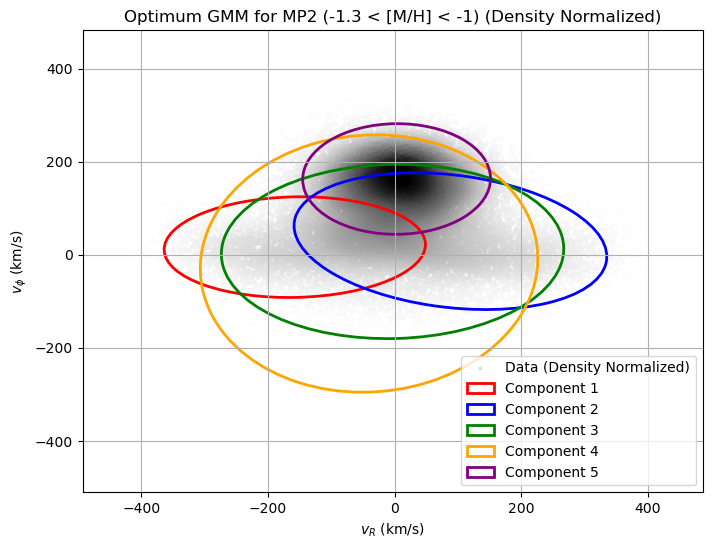

In [21]:
plot_gmm_ellipses(df_mp2, gmm_mp2, "MP2 (-1.3 < [M/H] < -1)",Xmin,Xmax)